In [1]:
using FourierFlows
using FourierFlows: parsevalsum2
using JLD2
using CairoMakie
using Printf
include("../../analysis/Notebooks/AnalysisUtils.jl")
include("../../rsw/RSWUtils.jl")

compute_rsw_fields (generic function with 1 method)

In [2]:
run_directory = "/vast/nad9961/rsw/64999185/"
Nsnapshots = count_key_snapshots(run_directory, "rsw")

4006

In [3]:
function compute_energy_data(run_directory, grid, snap_idx)
    Nsnapshots = count_key_snapshots(run_directory, "rsw")
    
    f, Cg2 = read_rsw_params(run_directory)
    params = (; f, Cg2)
    
    bases = compute_balanced_wave_bases(grid, params)
        
    t, rsw_sol = load_key_snapshot(run_directory, "rsw", snap_idx)
        
    dealias!(rsw_sol, grid)
    ((KE, PE, KEg, PEg, KEw, PEw, Eg, Ew), (KE_sum, PE_sum, KEg_sum, PEg_sum, KEw_sum, PEw_sum)) = compute_energy(rsw_sol, bases, grid, params)
    
    return t, Eg, Ew, KE, KEg, KEw, PE, PEg, PEw
end

function compute_energy(snapshot, bases, grid, params)
    uh = snapshot[:,:,1]
    vh = snapshot[:,:,2]
    ηh = snapshot[:,:,3]
    
    c₀, c₊, c₋ = compute_balanced_wave_weights(uh, vh, ηh, bases..., params)
    ((ugh, vgh, ηgh), (uwh, vwh, ηwh)) = wave_balanced_decomposition(uh, vh, ηh, grid, params)
    qh = @. 1im * grid.kr * vh - 1im * grid.l * uh - params.f * ηh

    ((KE,  KE_total),  (PE,  PE_total))  = compute_energetics(uh, vh, ηh, grid, params)
    ((KEg, KEg_total), (PEg, PEg_total)) = compute_energetics(ugh, vgh, ηgh, grid, params)
    ((KEw, KEw_total), (PEw, PEw_total)) = compute_energetics(uwh, vwh, ηwh, grid, params)

    Eg = abs2.(c₀) * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
    Ew = (abs2.(c₊) + abs2.(c₋)) * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)

    return ((KE, PE, KEg, PEg, KEw, PEw, Eg, Ew), (KE_total, PE_total, KEg_total, PEg_total, KEw_total, PEw_total))
end

function compute_energetics(uh, vh, ηh, grid, params)
    KE = 0.5 * (abs2.(uh) + abs2.(vh)) * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
    PE = 0.5 * params.Cg2 * abs2.(ηh)  * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)

    KE_total = 0.5 * (parsevalsum2(uh, grid) + parsevalsum2(vh, grid)) / grid.Lx / grid.Ly
    PE_total = 0.5 * params.Cg2 * parsevalsum2(ηh, grid) / grid.Lx / grid.Ly
    return ((KE, KE_total), (PE, PE_total))
end

compute_energetics (generic function with 1 method)

In [4]:
t, sol = load_key_snapshot(run_directory, "rsw", Nsnapshots)
grid = TwoDGrid(; Lx=2π, nx=512)
t, Eg, Ew, KE, KEg, KEw, APE, APEg, APEw = compute_energy_data(run_directory, grid, Nsnapshots)

(1227.8785f0, [0.000276433403876328 0.7688067875088257 … 0.2523943238124379 0.7688715095550702; 0.002148177649205137 0.08183267332621727 … 0.031321584512261226 0.013704551606818443; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.00016144663369065636 0.02845219665771134 … 0.011785461657809667 0.024670864953627924; 0.0032782824986053623 0.027684674415147065 … 0.0073755156210607185 0.011889935587856832; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [8.07233184278583e-5 0.08631669232195184 … 0.06652021086544674 0.08601644265247302; 0.002125919065849863 0.02011149543125257 … 0.01456099216779888 0.010083830917912375; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0384403380412982 … 0.03882989736884054 0.03844357681195854; 0.00010740887935693465 0.007439333796241142 … 0.005593140091475219 0.0012458682895135453; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [8.072331684532819e-5 0.012941263902253742 … 0.004104517712157852 0.011388578195617609; 0.0015475542403979355 0.013118672471308712 … 0.0024139

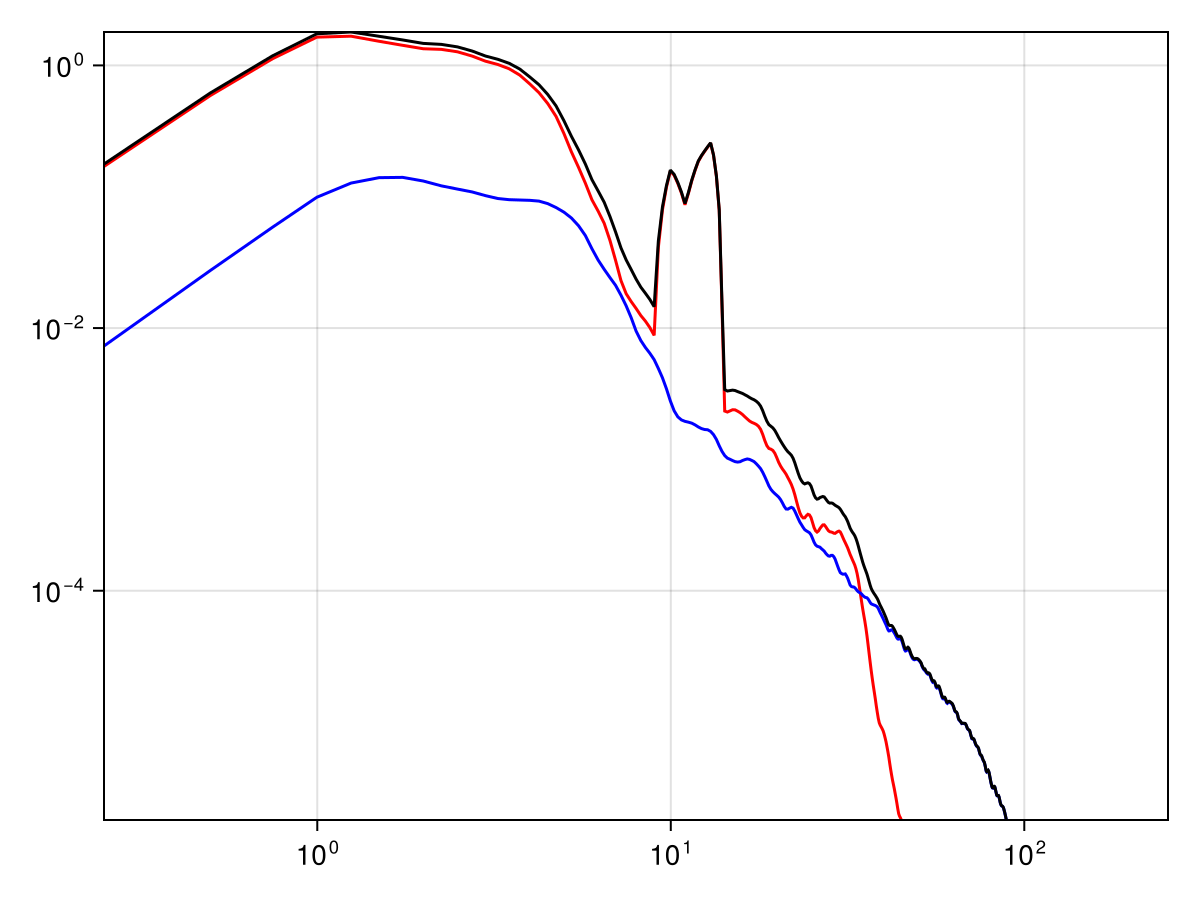

In [35]:
ρ, Egr = FourierFlows.radialspectrum(Eg, grid)
ρ, Ewr = FourierFlows.radialspectrum(Ew, grid)
ρ, Er = FourierFlows.radialspectrum(Eg+Ew, grid)

fig = Figure()
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, limits=((ρ[2], ρ[end]), (1e-6*maximum(Er), maximum(Er))))
lines!(ρ, Egr[:], color="red")
lines!(ρ, Ewr[:], color="blue")
lines!(ρ, Er[:], color="black")

fig